# This book combines corn weekly forecasts with an artificial bee colony algorithm

### CONTENTS

### 1 Imports
### 2 Define error functions
### 3 Load and evaluate individual forecasts
### 4 Set ABC parameters
### 5 Initialise ABC data structures
### 6 Define ABC functions
### 7 Complete ABC forecast combination
### 8 Compare ABC with naive combinations
### 9 Compare combinations with error-informed discretised search

# 1 Imports

In [8]:
import numpy as np
import pandas as pd

from scipy import stats

import random

import matplotlib.pyplot as plt
import matplotlib.dates

from google.colab import drive
import json

# 2 Define error functions

In [9]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns mean absolute percentage error
def mape(forecast, actual):
  return np.mean(np.abs(forecast - actual)/np.abs(actual))

In [10]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns root mean squared error
def rmse(forecast, valid):
    return (np.mean((forecast - valid)**2))**.5  # RMSE

# 3 Load and evaluate individual forecasts

In [11]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_weekly.csv'
corn_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
corn_df.columns = ['value']

# take only 1974 - 2017
corn_df = corn_df['1974-01-01':'2017-12-31']

# corn_df needs to lose last value becuase during process of VMD, the last value is lost
corn_df = corn_df[:-1]

# get validation set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(corn_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [12]:
# flatten the valid set for comparing with forecasts
true_valid = true_valid.values.flatten()

In [13]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
# Load emd_arima
with open('/content/gdrive/My Drive/outputs/emd_ARIMA_weekly_valid.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/My Drive/outputs/vmd_ARIMA_weekly_valid.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/My Drive/outputs/emd_RNN_weekly_valid.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/My Drive/outputs/vmd_RNN_weekly_valid.npy')

In [15]:
# Check shapes
print(true_valid.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)

(229,)
(229,)
(229,)
(229,)
(229,)


In [16]:
# Check individual mape scores
print(mape(emd_arima, true_valid))
print(mape(vmd_arima, true_valid))
print(mape(emd_RNN, true_valid))
print(mape(vmd_RNN, true_valid))

0.018572290850601796
0.01957756841608124
0.01923307724550019
0.01992787215562941


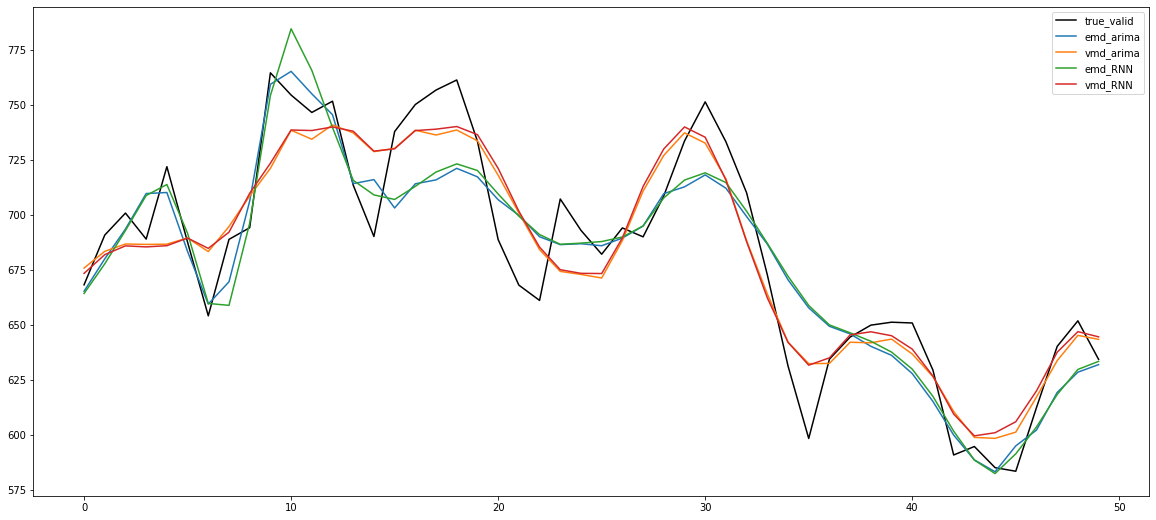

In [18]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_valid[100:150], label='true_valid', color='k')
plt.plot(emd_arima[100:150], label='emd_arima')
plt.plot(vmd_arima[100:150], label='vmd_arima')
plt.plot(emd_RNN[100:150], label='emd_RNN')
plt.plot(vmd_RNN[100:150], label='vmd_RNN')
plt.legend()
plt.show()

In [19]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN]))
model_matrix

array([[352.87344703, 358.43819049, 347.74206543, 358.48413086],
       [370.75693862, 370.11234352, 365.45291138, 370.74212646],
       [388.88583204, 385.96790809, 386.71716309, 385.86663818],
       [397.0668434 , 393.60068376, 398.59793091, 394.78134155],
       [394.96142333, 396.37093571, 396.22015381, 395.57086182],
       [389.6629838 , 396.11895053, 388.02957153, 395.01916504],
       [387.28903389, 391.65732706, 383.56661987, 390.73446655],
       [380.56192538, 389.2125449 , 379.56448364, 387.36199951],
       [384.69482575, 391.89323159, 381.12963867, 390.09539795],
       [393.30920921, 401.23930076, 390.27514648, 399.73464966],
       [405.05162347, 411.67341386, 402.87957764, 411.23278809],
       [422.60150207, 424.76844267, 419.4052124 , 423.79574585],
       [441.57922617, 435.5891413 , 438.67437744, 435.44122314],
       [457.25238095, 446.23056591, 455.62393188, 445.30331421],
       [462.51790795, 452.27955901, 463.0395813 , 451.11117554],
       [456.08819683, 446

# 4 Set ABC parameters

In [20]:
# make a variable counting number of base models involved
no_of_models = len(model_matrix[0])

# swarm size
SN = 350

# number of iterations through solution set
iter_stop_no = 5000

# the minimum possible weight during swarm initialisation
xmin = 0.1

# the maximum possible weight during swarm initialisation
xmax = 0.5

# the minimum number of bees in the elitist colony
min_elite_no = 8

# the number of tries without improvement, after which the solution is abandoned for new territory
trial_limit = 10

# 5 Initialise ABC data structures

In [21]:
# Make randomly initialized direction factor matrix
# This matrix makes it less likely that an unpromising avenue will be searched again in the same direction 

np.random.seed(42)
dir_factor = np.random.choice([-1,1], SN * no_of_models)
dir_factor = dir_factor.reshape(SN, no_of_models)
dir_factor

array([[-1,  1, -1, -1],
       [-1,  1, -1, -1],
       [-1,  1, -1, -1],
       ...,
       [-1, -1,  1,  1],
       [ 1,  1, -1,  1],
       [-1, -1,  1, -1]])

In [22]:
# Trial array, tracking the number of changes without getting any improvements
# Once any value exceeds the value of trial_limit, the corresponding solution will be abandoned in search of a new random solution

trial_arr = np.full(SN, 0)
trial_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
# Initialise the colony
colony = np.full((SN, no_of_models), xmin) + np.random.rand(SN, no_of_models) * (xmax - xmin)

# 6 Define ABC functions

In [24]:
# Takes model_matrix and the colony
# Returns a 1d array giving RMSE for every solution in colony
def evaluate_colony(model_matrix, colony, valid):

  colony_rmse = []

  for row in np.transpose(model_matrix.dot(np.transpose(colony))):
    colony_rmse.append(rmse(row, valid))
    
  return np.array(colony_rmse)

In [25]:
# Takes model_matrix, a single solution and the validation set
# Returns the rmse figure for that single solution
def evaluate_solution(model_matrix, solution, valid):
  return rmse(model_matrix.dot(solution), valid)

In [26]:
# Takes the number of bees to be in elitist colony at present, the colony evaluation and the colony
# Returns the solutions to make up current elitist colony
def generate_elitist_colony(elitist_no, colony_eval, colony):
  sort_ints = np.argsort(colony_eval)
  #return colony[sort_ints[:elitist_no]], colony_eval[sort_ints[-elitist_no::-1]]
  return colony[sort_ints[:elitist_no]]

In [27]:
# Takes the colony and its evaluation
# Returns a fitness evaluation of each solution
def generate_fitness_probs(colony, colony_eval):
  min_max_sum = max(colony_eval) + min(colony_eval)
  inverted_fitness = np.full(SN, min_max_sum)
  inverted_fitness = inverted_fitness - colony_eval
  inverted_fitness = inverted_fitness / sum(inverted_fitness)
  return inverted_fitness

In [28]:
# Take swarm size, current iteration, iter_stop_no and min_elite_no
# Return the number of bees to make up the elitist colony ar present
def elitist_no(SN, i, iter_stop_no, min_elite_no):
  return round(max(SN - (SN * (i / iter_stop_no)), min_elite_no))

In [29]:
# Take no_of_models, a solution, a random elitist solution, and the relevant row from dir_factor
# Return an altered version which is hoped to have lower error, as well as the location of the element which was altered

def generate_candidate(no_of_models, solution, elitist_solution, dir_factor_row):
  element = np.random.choice(no_of_models)
  
  candidate = solution.copy()

  candidate[element] += abs(candidate[element] - elitist_solution[element]) * dir_factor_row[element] * np.random.rand()

  return candidate, element

In [30]:
# This function makes use of all above information and implements ABC algorithm in full as outlined by Wang
def LL_ABC(SN, iter_stop_no, no_of_models, valid, xmin, xmax, min_elite_no, trial_limit):

  np.random.seed(42)
  elite_no = elitist_no(SN=SN, i=0, iter_stop_no=iter_stop_no, min_elite_no=min_elite_no)

  lowest_err = 99
  best_solution = []
  elitist_colony = generate_elitist_colony(elitist_no=elite_no, colony_eval=evaluate_colony(model_matrix, colony, valid), colony=colony)

  # Employed bee phase
  for i in range(SN):
    solution = colony[i]
    solution_error = evaluate_solution(model_matrix, solution, valid)

    if solution_error < lowest_err:
      lowest_err = solution_error
      best_solution = solution.copy()

    candidate, element = generate_candidate(no_of_models=no_of_models
                                            ,solution=solution
                                            ,elitist_solution=elitist_colony[np.random.choice(elite_no)]
                                            ,dir_factor_row=dir_factor[i])

    candidate_error = evaluate_solution(model_matrix, candidate, valid)

    if candidate_error < solution_error:
      trial_arr[i] = 0
      colony[i] = candidate.copy()
      if candidate_error < lowest_err:
        lowest_err = candidate_error
        best_solution = candidate.copy()
    else:
      dir_factor[i][element] *= -1
      trial_arr[i] += 1

  for i in range(iter_stop_no):

      fitness_arr = generate_fitness_probs(colony=colony
                                           ,colony_eval=evaluate_colony(model_matrix, colony, valid))
    
      elite_no = elitist_no(SN=SN, i=i, iter_stop_no=iter_stop_no, min_elite_no=min_elite_no)
      elitist_colony = generate_elitist_colony(elitist_no=elite_no, colony_eval=evaluate_colony(model_matrix, colony, valid), colony=colony)
      t = 0

      # Onlooker phase
      while t < SN:

        fitness_threshold = np.random.rand()

        for j in range(SN):
          if fitness_arr[j] > fitness_threshold:
            solution = colony[j]
            solution_error = evaluate_solution(model_matrix, solution, valid)

            if solution_error < lowest_err:
              lowest_err = solution_error
              best_solution = solution.copy()

            candidate, element = generate_candidate(no_of_models=no_of_models
                                                    ,solution=solution
                                                    ,elitist_solution=elitist_colony[np.random.choice(elite_no)]
                                                    ,dir_factor_row=dir_factor[j])
            
            candidate_error = evaluate_solution(model_matrix, candidate, valid)

            if candidate_error < solution_error:
              trial_arr[j] = 0
              colony[j] = candidate.copy()
              if candidate_error < lowest_err:
                lowest_err = candidate_error
                best_solution = candidate.copy()
            else:
              dir_factor[j][element] *= -1
              trial_arr[j] += 1

            t += 1

      # Scout phase
      for j in range(SN):
        if trial_arr[j] > trial_limit:
          colony[j] = np.full(no_of_models, xmin) + np.random.rand(no_of_models) * (xmax - xmin)
          trial_arr[j] = 0

  return lowest_err, best_solution

# 7 Complete ABC forecast combination

In [31]:
lowest_err, best_solution = LL_ABC(SN, iter_stop_no, no_of_models, true_valid, xmin, xmax, min_elite_no, trial_limit)

In [32]:
print(lowest_err, best_solution)
print(rmse(model_matrix.dot(best_solution), true_valid))
print(mape(model_matrix.dot(best_solution), true_valid))

13.848915783038182 [ 0.08728169  0.59377955  0.43502419 -0.11466327]
13.848915783038182
0.01731626177003656


# 8 Compare ABC with naive combinations

In [33]:
# mean
mn = model_matrix.mean(axis=1)

print(mape(mn, true_valid))

0.01744542713383512


In [34]:
# trimmed mean
trimean = stats.trim_mean(model_matrix, 0.25, axis=1)

print(mape(trimean, true_valid))

0.017531221781172168


In [35]:
# median
mdn = np.median(model_matrix, axis=1)

print(mape(mdn, true_valid))

0.017531221781172168


# 9 Compare combinations with error-informed discretised search

In [36]:
mape_list = [mape(emd_arima, true_valid),
mape(vmd_arima, true_valid),
mape(emd_RNN, true_valid),
mape(vmd_RNN, true_valid)]

sum_mape = sum(mape_list)
mape_weights = [err / sum_mape for err in mape_list]
print(mape_weights)

[0.24022890421962603, 0.25323197045062223, 0.24877604537989573, 0.25776307994985603]


In [37]:
inv_mape_list = [1/mape(emd_arima, true_valid),
1/mape(vmd_arima, true_valid),
1/mape(emd_RNN, true_valid),
1/mape(vmd_RNN, true_valid)]

sum_inv_mape = sum(inv_mape_list)
inv_mape_weights = [err / sum_inv_mape for err in inv_mape_list]
print(inv_mape_weights)

[0.25999212088800167, 0.24664193148881972, 0.2510596316107715, 0.24230631601240712]


In [38]:
print(mape(model_matrix.dot(inv_mape_weights), true_valid))

0.017445709181493647


In [39]:
def discretised_search(step_size, mape_weights, inv_mape_weights, stop_no):
  solution = inv_mape_weights.copy()

  no_improvements = 0
  els = [a for a in range(len(mape_weights))]
  current_mape = mape(model_matrix.dot(inv_mape_weights), true_valid)

  while no_improvements < stop_no:
    decrease_el = random.choices(els, mape_weights, k=1)
    increase_el = random.choices(els, inv_mape_weights, k=1)
    solution[decrease_el[0]] -= step_size
    solution[increase_el[0]] += step_size

    new_mape = mape(model_matrix.dot(solution), true_valid)
    if new_mape < current_mape:
      current_mape = new_mape
      no_improvmements = 0
    else:
      no_improvements += 1
      solution[decrease_el[0]] += step_size
      solution[increase_el[0]] -= step_size

  return solution

In [40]:
eids = discretised_search(0.01, mape_weights, inv_mape_weights, 1000)
print(eids)

[-0.12000787911199841, 1.3566419314888205, 0.5710596316107718, -0.8076936839875936]


In [41]:
print(mape(model_matrix.dot(eids), true_valid))

0.0172511634486786


# End